# Predicting Max Temperature using Machine Learning
*Junsoo Derek Shin*
<br>
*May 2018*
***
### Purpose
The purpose of the project is to predict max temperatures of the days in April 2018 using machine learning techniques.

The general guide on the machine learning concepts and the inspiration to apply them came from these two sources:
1. https://www.kaggle.com/learn/machine-learning
2. http://stackabuse.com/using-machine-learning-to-predict-the-weather-part-2


### 1. Get and Load Weather Underground Data

**`extract_weather_data()`** function asks the Weather Underground API for the historic data and writes the returned JSON data into a text file. The delay is put in, so that the number of requests doesn't exceed the 10-requests-per-minute limit. There is also daily limit of 500 requests, so `days` argument should not be greater than 500. I have already run this function and gathered data from January 1, 2014 to April 30, 2018, and the data is available in the `weatherdata.txt` file.

In [1]:
import requests
from datetime import datetime, timedelta
import time
import json

from collections import namedtuple
import pandas as pd

In [2]:
# get history JSON data from the Weather Underground API
# def extract_weather_data(api_key, base_url, target_date, days):
#     with open('weatherdata.txt', 'a') as outfile:
#         for _ in range(days):
#             request = base_url.format(api_key, target_date.strftime('%Y%m%d'))
#             response = requests.get(request)
#             if response.status_code == 200:
#                 data = response.json()["history"]["dailysummary"][0]
#                 json.dump(data, outfile)
#                 outfile.write('\n')
#             time.sleep(6)
#             target_date += timedelta(days=1)

**`fill_dateframe()`** function reads the text file filled with JSON objects and creates a Pandas DataFrame from it. The `target_date` argument is the starting date of this weather text file and should be a `datetime` object like `datetime(2014, 1, 1)`. This date increments as we create the DataFrame and works as the index. The `namedtuple` is similar to a struct or class and lets us use attributes, so that the code is more readable.

In [3]:
# from the text file of JSON objects, create a list of namedtuples, and use it
# to create a DataFrame
def fill_dataframe(target_date):
    features = ["date", "meantempm", "meandewptm", "meanpressurem", 
                "maxhumidity", "minhumidity", "maxtempm", "mintempm", 
                "maxdewptm", "mindewptm", "maxpressurem", "minpressurem", 
                "precipm"]
    DailySummary = namedtuple("DailySummary", features)
    records = []
    with open('weatherdata.txt', 'r') as f:
        for line in f:
            data = json.loads(line)
            records.append(DailySummary(
                date = target_date,
                meantempm = data["meantempm"],
                meandewptm = data["meandewptm"],
                meanpressurem = data["meanpressurem"],
                maxhumidity = data["maxhumidity"],
                minhumidity = data["minhumidity"],
                maxtempm = data["maxtempm"],
                mintempm = data["mintempm"],
                maxdewptm = data["maxdewptm"],
                mindewptm = data["mindewptm"],
                maxpressurem = data["maxpressurem"],
                minpressurem = data["minpressurem"],
                precipm = data["precipm"],
            ))
            target_date += timedelta(days=1)
    df = pd.DataFrame(records, columns=features).set_index('date')
    return df

In [4]:
target_date = datetime(2014, 1, 1)
days = 365
# extract_weather_data(API_KEY, BASE_URL, target_date, days)

In [5]:
data = fill_dataframe(target_date)

All of the columns are `object` (or `string`). Let's convert them into numeric data, so that it's easier to work with.

In [6]:
data.dtypes

meantempm        object
meandewptm       object
meanpressurem    object
maxhumidity      object
minhumidity      object
maxtempm         object
mintempm         object
maxdewptm        object
mindewptm        object
maxpressurem     object
minpressurem     object
precipm          object
dtype: object

In [7]:
data = data.apply(pd.to_numeric, errors='ignore')

In [8]:
data.dtypes

meantempm          int64
meandewptm         int64
meanpressurem    float64
maxhumidity        int64
minhumidity        int64
maxtempm           int64
mintempm           int64
maxdewptm          int64
mindewptm          int64
maxpressurem       int64
minpressurem       int64
precipm           object
dtype: object

In [9]:
data['precipm'].unique()

array(['0.00', '9.65', '4.83', '1.02', '8.13', 'T', '0.51', '13.72',
       '20.07', '0.76', '2.79', '0.25', '4.32', '28.19', '25.40', '7.87',
       '8.38', '5.59', '6.35', '2.03', '7.37', '24.64', '56.64', '11.18',
       '6.60', '5.84', '17.02', '15.75', '9.14', '1.27', '5.08', '3.81',
       '8.89', '8.64', '1.52', '16.51', '4.57', '12.19', '3.56', '19.81',
       '21.59', '7.11', '47.75', '26.92', '3.30', '29.46', '4.06',
       '16.00', '22.10', '57.15', '14.99', '41.66', '36.58', '2.54',
       '27.69', '73.66', '10.92', '14.22', '14.48', '3.05', '18.03',
       '24.13', '2.29', '1.78', '9.40', '22.35', '9.91', '20.32', '6.86',
       '5.33', '15.49', '23.11', '18.80', '10.16', '43.69', '36.32',
       '12.70', '28.45', '12.45', '21.08', '16.76', '62.48', '18.54',
       '21.84', '7.62', '10.67', '13.97', '19.30', '6.10', '25.91',
       '35.05', '30.99', '24.38', '20.57', '28.96', '10.41', '26.16',
       '28.70', '22.61', '46.74', '25.15', '13.46', '11.94', '19.56',
       '41

`precipm` column was the only column that couldn't be converted into numbers, and the reason was that it had values such as `'T'`, which stands for "Trace" or a very litte amount of precipitation. Since "Trace" should be different from zero precipitation, I will assign an arbitrary value of 0.01 for now.

In [10]:
data = data.apply(pd.to_numeric, errors='coerce')
trace_rows = data['precipm'].isnull()
data.loc[trace_rows, 'precipm'] = 0.01

In [11]:
data.dtypes

meantempm          int64
meandewptm         int64
meanpressurem    float64
maxhumidity        int64
minhumidity        int64
maxtempm           int64
mintempm           int64
maxdewptm          int64
mindewptm          int64
maxpressurem       int64
minpressurem       int64
precipm          float64
dtype: object

In [12]:
data['precipm'].unique()

array([0.000e+00, 9.650e+00, 4.830e+00, 1.020e+00, 8.130e+00, 1.000e-02,
       5.100e-01, 1.372e+01, 2.007e+01, 7.600e-01, 2.790e+00, 2.500e-01,
       4.320e+00, 2.819e+01, 2.540e+01, 7.870e+00, 8.380e+00, 5.590e+00,
       6.350e+00, 2.030e+00, 7.370e+00, 2.464e+01, 5.664e+01, 1.118e+01,
       6.600e+00, 5.840e+00, 1.702e+01, 1.575e+01, 9.140e+00, 1.270e+00,
       5.080e+00, 3.810e+00, 8.890e+00, 8.640e+00, 1.520e+00, 1.651e+01,
       4.570e+00, 1.219e+01, 3.560e+00, 1.981e+01, 2.159e+01, 7.110e+00,
       4.775e+01, 2.692e+01, 3.300e+00, 2.946e+01, 4.060e+00, 1.600e+01,
       2.210e+01, 5.715e+01, 1.499e+01, 4.166e+01, 3.658e+01, 2.540e+00,
       2.769e+01, 7.366e+01, 1.092e+01, 1.422e+01, 1.448e+01, 3.050e+00,
       1.803e+01, 2.413e+01, 2.290e+00, 1.780e+00, 9.400e+00, 2.235e+01,
       9.910e+00, 2.032e+01, 6.860e+00, 5.330e+00, 1.549e+01, 2.311e+01,
       1.880e+01, 1.016e+01, 4.369e+01, 3.632e+01, 1.270e+01, 2.845e+01,
       1.245e+01, 2.108e+01, 1.676e+01, 6.248e+01, 

### 2. Add Features/Columns
What we want to predict is clear: it's `maxtempm`. However, we cannot use the data from the same date to train our model because we won't have those data from that day. So, one way to go about this is adding columns of measurements from the previous days. For example, for `meanpressurem`, we would have columns, such as `meanpressurem_1`, `meanpressurem_2`, `meanpressurem_3`, which are measurements from 1, 2 and 3 days prior.

So let's add the columns for 1, 2 and 3-days-prior measurements for every column except for the temperature columns. For the first few rows at the top, we need a buffer because we don't have the prior-days data for them.

In [13]:
# given a feature and the number of prior days, add column(s) to the DataFrame
def derive_nth_day_feature(df, feature, N):
    num_rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i] for i in range(0, num_rows-N)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = nth_prior_measurements

In [14]:
for feature in data.columns:
    for N in range(1, 4):
        derive_nth_day_feature(data, feature, N)

In [15]:
data.columns

Index(['meantempm', 'meandewptm', 'meanpressurem', 'maxhumidity',
       'minhumidity', 'maxtempm', 'mintempm', 'maxdewptm', 'mindewptm',
       'maxpressurem', 'minpressurem', 'precipm', 'meantempm_1', 'meantempm_2',
       'meantempm_3', 'meandewptm_1', 'meandewptm_2', 'meandewptm_3',
       'meanpressurem_1', 'meanpressurem_2', 'meanpressurem_3',
       'maxhumidity_1', 'maxhumidity_2', 'maxhumidity_3', 'minhumidity_1',
       'minhumidity_2', 'minhumidity_3', 'maxtempm_1', 'maxtempm_2',
       'maxtempm_3', 'mintempm_1', 'mintempm_2', 'mintempm_3', 'maxdewptm_1',
       'maxdewptm_2', 'maxdewptm_3', 'mindewptm_1', 'mindewptm_2',
       'mindewptm_3', 'maxpressurem_1', 'maxpressurem_2', 'maxpressurem_3',
       'minpressurem_1', 'minpressurem_2', 'minpressurem_3', 'precipm_1',
       'precipm_2', 'precipm_3'],
      dtype='object')

We don't need the measurements on the same day as the temperatures because we won't have them for the days we are trying to predict. If we can have those measurements, we can probably have temperatures for those days as well. So let's drop those columns.

We also see that the columns are missing certain amount of values because of the missing n_day prior values. Other than those rows, everything seems to be filled in. Although every row is valuable, I don't want to impute values that could be way off, let's drop those 1-to-3 rows and obtain non-null data all around.

In [16]:
features_to_drop = ['meandewptm', 'maxdewptm', 'mindewptm',
                    'meanpressurem', 'maxpressurem', 'minpressurem',
                    'maxhumidity', 'minhumidity',
                    'precipm']
data.drop(features_to_drop, axis=1, inplace=True)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1581 entries, 2014-01-01 to 2018-04-30
Freq: D
Data columns (total 39 columns):
meantempm          1581 non-null int64
maxtempm           1581 non-null int64
mintempm           1581 non-null int64
meantempm_1        1580 non-null float64
meantempm_2        1579 non-null float64
meantempm_3        1578 non-null float64
meandewptm_1       1580 non-null float64
meandewptm_2       1579 non-null float64
meandewptm_3       1578 non-null float64
meanpressurem_1    1580 non-null float64
meanpressurem_2    1579 non-null float64
meanpressurem_3    1578 non-null float64
maxhumidity_1      1580 non-null float64
maxhumidity_2      1579 non-null float64
maxhumidity_3      1578 non-null float64
minhumidity_1      1580 non-null float64
minhumidity_2      1579 non-null float64
minhumidity_3      1578 non-null float64
maxtempm_1         1580 non-null float64
maxtempm_2         1579 non-null float64
maxtempm_3         1578 non-null float64
mintempm_1  

In [18]:
data.dropna(axis=0, inplace=True)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1578 entries, 2014-01-04 to 2018-04-30
Freq: D
Data columns (total 39 columns):
meantempm          1578 non-null int64
maxtempm           1578 non-null int64
mintempm           1578 non-null int64
meantempm_1        1578 non-null float64
meantempm_2        1578 non-null float64
meantempm_3        1578 non-null float64
meandewptm_1       1578 non-null float64
meandewptm_2       1578 non-null float64
meandewptm_3       1578 non-null float64
meanpressurem_1    1578 non-null float64
meanpressurem_2    1578 non-null float64
meanpressurem_3    1578 non-null float64
maxhumidity_1      1578 non-null float64
maxhumidity_2      1578 non-null float64
maxhumidity_3      1578 non-null float64
minhumidity_1      1578 non-null float64
minhumidity_2      1578 non-null float64
minhumidity_3      1578 non-null float64
maxtempm_1         1578 non-null float64
maxtempm_2         1578 non-null float64
maxtempm_3         1578 non-null float64
mintempm_1  

Let's split the data into **`train_data`** and **`april_data`**, so that we can train our models with **`train_data`** and eventually test them with **`april_data`**.

In [20]:
april_data = data[data.index >= datetime(2018, 4, 1)]
train_data = data.drop(april_data.index, axis=0)
april_data.info()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2018-04-01 to 2018-04-30
Freq: D
Data columns (total 39 columns):
meantempm          30 non-null int64
maxtempm           30 non-null int64
mintempm           30 non-null int64
meantempm_1        30 non-null float64
meantempm_2        30 non-null float64
meantempm_3        30 non-null float64
meandewptm_1       30 non-null float64
meandewptm_2       30 non-null float64
meandewptm_3       30 non-null float64
meanpressurem_1    30 non-null float64
meanpressurem_2    30 non-null float64
meanpressurem_3    30 non-null float64
maxhumidity_1      30 non-null float64
maxhumidity_2      30 non-null float64
maxhumidity_3      30 non-null float64
minhumidity_1      30 non-null float64
minhumidity_2      30 non-null float64
minhumidity_3      30 non-null float64
maxtempm_1         30 non-null float64
maxtempm_2         30 non-null float64
maxtempm_3         30 non-null float64
mintempm_1         30 non-null float64
mintempm_2       

### 3. Linear Regression
Now we can build our first model using linear regression! Linear regression requires that the features we are using and the target variable we are trying to predict have linear relationships. One way to assess that is by calculating Pearson correlation coefficients. These values range from -1 to 1, and the values close to -1 and 1 mean that the features have strong linear relationships with the target variable, and values close to 0 mean that they have weak linear relationships with the target variable.

In [21]:
train_data.corr()[['maxtempm']].sort_values('maxtempm')

,maxtempm
maxpressurem_1,-0.178263
maxpressurem_3,-0.155820
maxpressurem_2,-0.127825
precipm_2,-0.093009
precipm_1,-0.091274
precipm_3,-0.078400
meanpressurem_1,-0.014725
meanpressurem_3,-0.008143
meanpressurem_2,0.027470
minhumidity_2,0.059617


It looks like the features with temperature and dew point have linear relationships with max temperature.

In [22]:
linear_features = [feature for feature in train_data.columns
                                       if 'temp' in feature or
                                          'dewpt' in feature]

The first model will use linear regression. It will train on 80% of the data and test on the 20% of the data. Using cross validation, we will cut the data in five, rotate the training-testing-data pairs, and then calculate the mean of those five scores, which will be the final score for this model.

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

X = train_data[linear_features].drop(['meantempm', 'maxtempm', 'mintempm'], axis=1)
y = train_data['maxtempm']

scores = -1 * cross_val_score(LinearRegression(),
                              X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')
scores.mean()

3.4218877102056657

In [24]:
from sklearn.metrics import mean_absolute_error

prev_maxtemp = X['maxtempm_1']
mean_absolute_error(y, prev_maxtemp)

3.7816537467700257

Although the mean error from the linear regression model is slightly better than just using the max temperatures from a day before, the error of 3.42 degrees Celsius (6.16 degrees Fahrenheit) is pretty high. Let's see if we can improve our predictions with another technique.

### 4. Decision Tree, Random Forest and XGBoost

In [25]:
X = train_data.drop(['meantempm', 'maxtempm', 'mintempm'], axis=1)
y = train_data['maxtempm']

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

for max_leaf_nodes in [5, 50, 500, 5000]:
    scores = -1 * cross_val_score(DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes),
                            X, y,
                            cv=5,
                            scoring='neg_mean_absolute_error')
    print(str(max_leaf_nodes), str(scores.mean()))

5 4.101516419277191
50 4.040956903482137
500 4.903717267374956
5000 4.93354003549431


In [27]:
from sklearn.ensemble import RandomForestRegressor

scores = -1 * cross_val_score(RandomForestRegressor(50),
                              X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')
scores.mean()

3.531410627414135

In [28]:
from xgboost import XGBRegressor

scores = -1 * cross_val_score(XGBRegressor(n_estimators=1000, learning_rate=0.005),
                              X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')
scores.mean()

3.4811722936642946

### 5. Predict April 2018

From the models trained and tested on the 3 years of data, the linear regression model seems to be the most accurate model, so we will use the linear regression model to predict the daily maximum temperatures of April 2018. First, let's train the model using the entire 3 years of data (not just 80% of them) since the April data will be our test data anyway. Then using the April data, we will make predictions.

In [29]:
train_y = train_data['maxtempm']
train_X = train_data[linear_features].drop(['meantempm', 'maxtempm', 'mintempm'], axis=1)
test_y = april_data['maxtempm']
test_X = april_data[linear_features].drop(['meantempm', 'maxtempm', 'mintempm'], axis=1)

linear_model = LinearRegression()
linear_model.fit(train_X, train_y)

predictions = linear_model.predict(test_X)
print("Linear Regression model's mean absolute error: "+ str(mean_absolute_error(test_y, predictions)))

Linear Regression model's mean absolute error: 4.220550906093899


Let's create two naive benchmarks. The first benchmark will use previous-day measurements as its predictions. The second benchmark will use previous-year measurements as its predictions.

In [30]:
prev_day_benchmark = april_data['maxtempm_1']
prev_year_benchmark = train_data.loc[(train_data.index >= datetime(2017, 4, 1)) & 
                                     (train_data.index <= datetime(2017, 4, 30))]['maxtempm']
print("prev_day MAE: " + str(mean_absolute_error(test_y, prev_day_benchmark)))
print("prev_year MAE: " + str(mean_absolute_error(test_y, prev_year_benchmark)))

prev_day MAE: 4.966666666666667
prev_year MAE: 7.733333333333333


April 2018 was a tough month to predict maximum temperatures. Maximum temperatures seemed to have changed day-to-day, and they were even more different from those of April 2017. Both benchmarks and our linear regression model performed with, I would say, large errors. However, the linear regression model does do better than the naive benchmarks, so this is a decent start. After studying more about the machine learning algorithms, I want to figure out what made the algorithms I used here struggled.

### 6. Attempt to Understand What Happened

Let's look at how my predictions and the actual maximum temperatures look on a scatterplot. If the predicitons were good, the plot would show a straight, diagonal line.

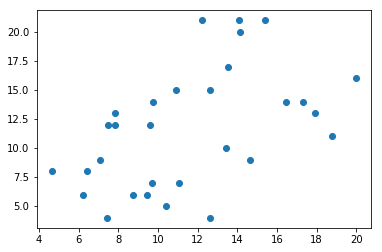

In [31]:
from matplotlib import pyplot as plt

plt.scatter(predictions, test_y)
plt.show()

The plot looks more like two diagonal lines, and really not a straight line that I wanted.

Let's check if there were any outliers in my training data that I missed.

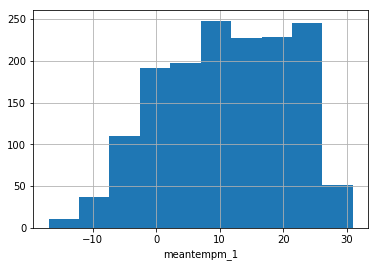

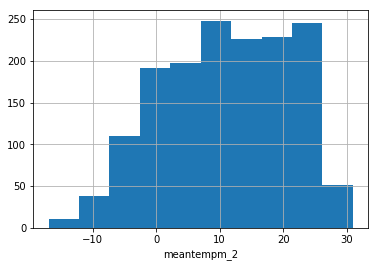

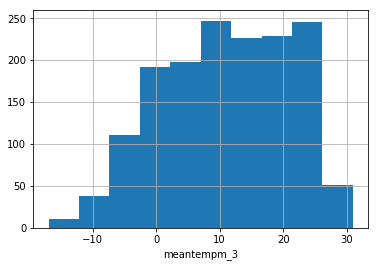

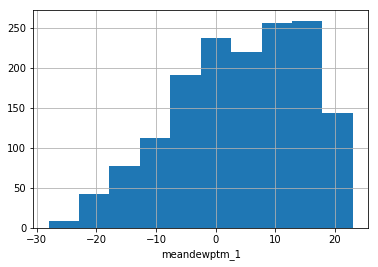

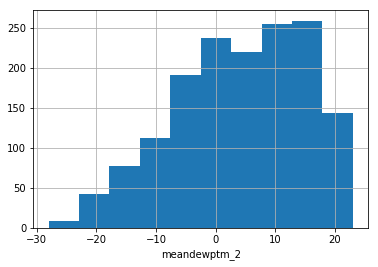

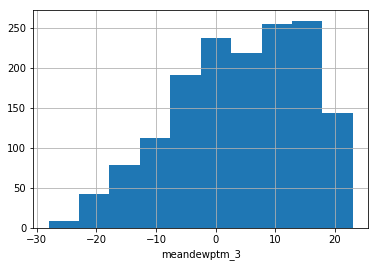

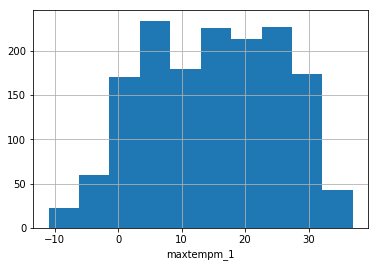

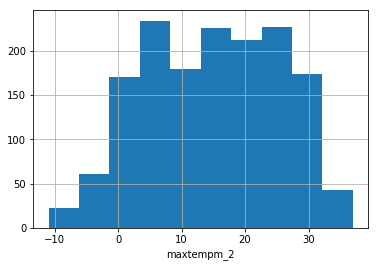

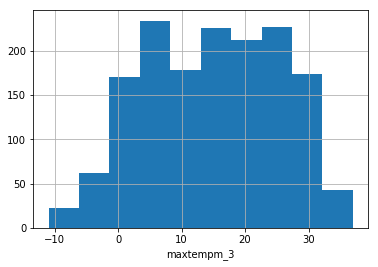

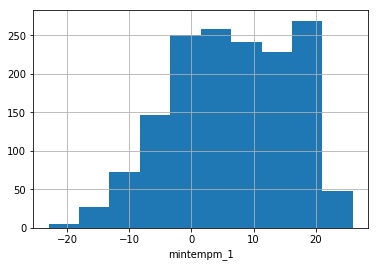

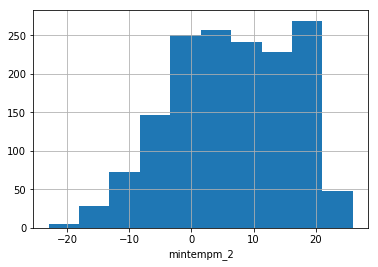

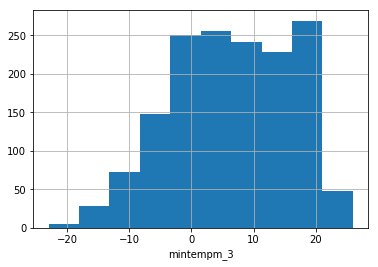

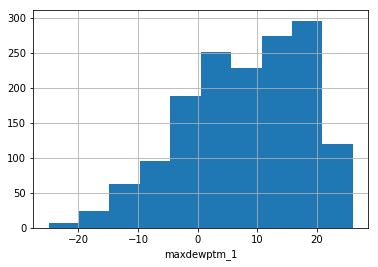

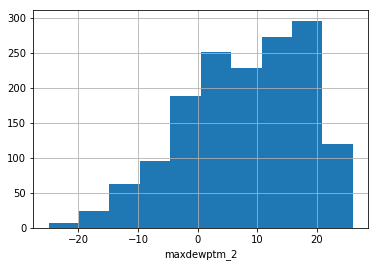

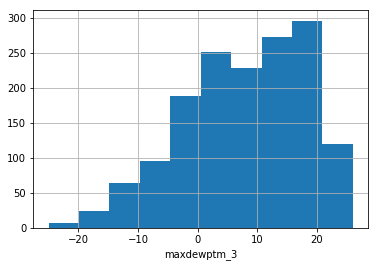

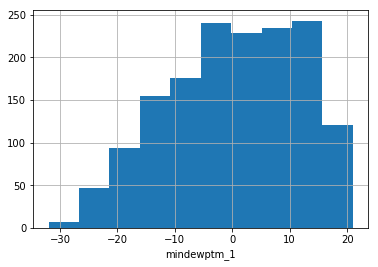

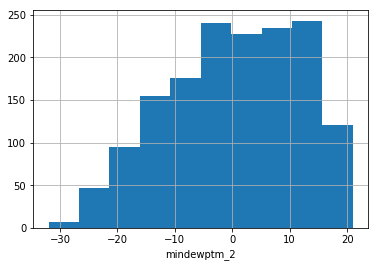

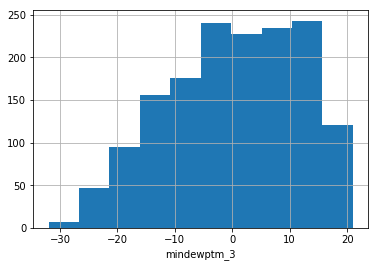

In [32]:
features_used = [feature for feature in linear_features 
                                     if feature not in ['meantempm', 'maxtempm', 'mintempm']]
for feature in features_used:
    train_data[feature].hist()
    plt.xlabel(feature)
    plt.show()

There doesn't seem to be many outliers in our training data.

Were the 2018 April really strange?

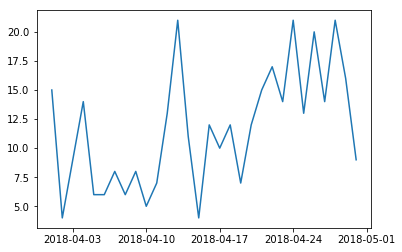

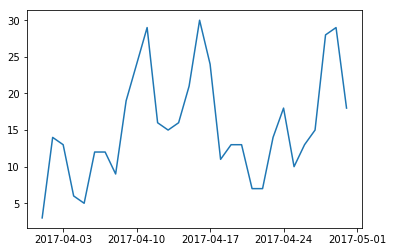

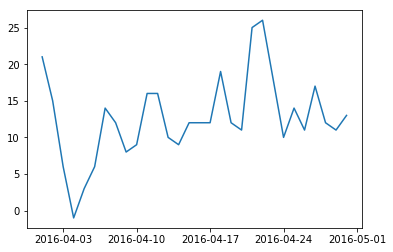

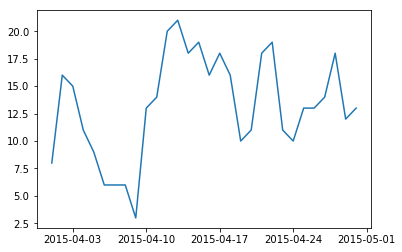

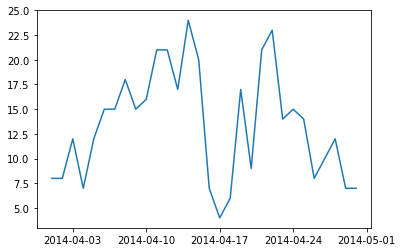

In [33]:
plt.plot(test_y)
plt.show()
plt.plot(train_data[(train_data.index >= datetime(2017, 4, 1)) & (train_data.index <= datetime(2017, 4, 30))]['maxtempm'])
plt.show()
plt.plot(train_data[(train_data.index >= datetime(2016, 4, 1)) & (train_data.index <= datetime(2016, 4, 30))]['maxtempm'])
plt.show()
plt.plot(train_data[(train_data.index >= datetime(2015, 4, 1)) & (train_data.index <= datetime(2015, 4, 30))]['maxtempm'])
plt.show()
plt.plot(train_data[(train_data.index >= datetime(2014, 4, 1)) & (train_data.index <= datetime(2014, 4, 30))]['maxtempm'])
plt.show()

It doesn't look like it.

It is true that using the temperature and dew point measurements in the 3 previous days to predict the maximum temperature for the next day seemed difficult even during the training of the model. Perhaps the model should have been more strongly fit (maybe it's underfit at the moment), or perhaps the model should have been trained on the April data only, or perhaps only the strongly-correlated variables should have been used to train the model.

In [34]:
my_preds = linear_model.predict(train_X)
print(str(mean_absolute_error(train_y, my_preds)))

3.387166415901749


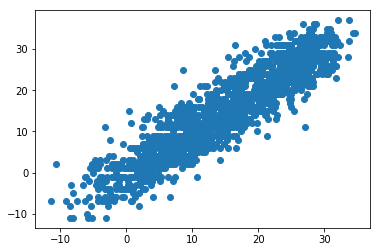

In [35]:
plt.scatter(my_preds, train_y)
plt.show()

Let's try training a linear regression model only on the past April data from 2014 to 2017.

In [36]:
all_april_train = train_data[train_data.index.month == 4]
all_april_train_X = all_april_train[features_used]
all_april_train_y = all_april_train['maxtempm']
april_linear_regression_model = LinearRegression()
april_linear_regression_model.fit(all_april_train_X, all_april_train_y)

april_preds = april_linear_regression_model.predict(test_X)
print("Linear Regression model's mean absolute error: "+ str(mean_absolute_error(test_y, april_preds)))

Linear Regression model's mean absolute error: 4.852350302903503


Only using the April data did worse than using the entire 4 years of data.